# Development in Danish unemployment, 2007-2020

Unemployment has forever and will likely forever be an important statistic for determining the well-being of a countries economy and its business cycle. Its relationship with inflation has also been an economic talking point regarding the Philips Curve. 2020 and most of 2021 have been centered around the Covid-19 crisis and its effect on various topics. How the Covid-19 has affected unemployment is one of these questions.

In the following assignment, we would like to shed light on how unemployment has been changing throughout the last decade and highlight how covid-19 has affected primarily municipalities.

**Import and set magics**

In [1]:
import numpy as np
import pandas as pd
import datetime
import ipywidgets as widgets
import pandas_datareader 
import pydst # install with pip install git+https://github.com/elben10/pydst
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid') 
pd.options.mode.chained_assignment = None  #Avoid pandas giving SettingWithCopy warnings

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
#No local modules used

# Read, clean and merge data

We start by downloading unemployment data using pydst - Danish Statistical Banks Python integration:

In [2]:
Dst = pydst.Dst(lang='en')
Dst.get_subjects()
tables = Dst.get_tables(subjects=['04'])
tables[tables.id == 'AUF01']
unempl_pers = Dst.get_variables(table_id='AUF01')

All tables within the Danish Statistical Bank include a long list of different variables. Within these variables, there are ID numbers that determine, what data we download from our chosen table. We find the possible IDs for the chosen variables within the table and prints them with their associated text to describe the IDs:

In [3]:
for id in ['YDELSESTYPE','ALDER','KØN']:
    
    print(id)
    values = unempl_pers.loc[unempl_pers.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

YDELSESTYPE
 id = TOT, text = Gross unemployment
 id = LDP, text = Net unemployed recipients of unemployment benefits
 id = LKT, text = Net unemployed recipients of social assistance
 id = ADP, text = Activation of persons on unemployment benefits
 id = AKT, text = Activation of persons on social assistance (prepared for employment)
ALDER
 id = TOT, text = Age, total
 id = 16-24, text = 16-24 years
 id = 25-29, text = 25-29 years
 id = 30-39, text = 30-39 years
 id = 40-49, text = 40-49 years
 id = 50-59, text = 50-59 years
 id = 6099, text = 60 year and over
KØN
 id = TOT, text = Total
 id = M, text = Men
 id = K, text = Women


We now use the IDs found to write, which variables we want to include for each column and import data from the table_id with the variables we want. We include two tables here, since both include unemployment data. The difference between them are that AUF1 holds non-verified numbers, but they are up to date with the current month. AUF2 holds actual unemployment numbers, but has a lag since verification can only happen with a couple of months lag.

In [4]:
variables = {'OMRÅDE':['*'],'YDELSESTYPE':['TOT'],'ALDER':['TOT'],'KØN':['*'],'TID':['*']}
unempl_AUF1 = Dst.get_data(table_id= 'AUF01', variables=variables)
unempl_AUF2 = Dst.get_data(table_id= 'AUF02', variables=variables)

We rewrite the TID parameter to be in datetime (We go from ex. 2020M01 to 2020-01-01):

In [5]:
unempl_AUF1.loc[:,'TID']= pd.to_datetime(unempl_AUF1.loc[:,'TID'].str.replace('M',''),format='%Y%m')
unempl_AUF2.loc[:,'TID']= pd.to_datetime(unempl_AUF2.loc[:,'TID'].str.replace('M',''),format='%Y%m')

We chose to merger the two tables together, using the actual unemployment numbers (AUF2) as our base and then stacking recent numbers (AUF1) on top for the months not available in AUF2.

In [6]:
I = (unempl_AUF1["TID"] > "2020-08-01") #Choose to stack only rows in AUF1, where there are newer data than in AUF2
unempl_AUF1 = unempl_AUF1.loc[I == True] #Overwrite the variable, where I is true.
outer = pd.merge(unempl_AUF1, unempl_AUF2, how='outer') #merge the two data sets

**Beginning of data cleaning**

We start out data cleaning by renaming the column names, which were originally in Danish, to English. We the drop non-useful columns and sort the table by municipality *then* time.

In [7]:
unempl = outer.copy()
unempl.rename(columns = {"OMRÅDE": "municipality", "ALDER":"age", "KØN":"gender","TID":"time","INDHOLD":"unemployed"}, inplace=True) #Renames the columns from Danish to English
drop_columns = ["YDELSESTYPE", "AKASSE"] #Drops the data from YDELSESTYPE and AKASSE as they are unimportant for this assignment
unempl.drop(drop_columns, axis=1, inplace=True)
unempl = unempl.sort_values(['municipality', 'time']) #Sorts the dataset by municipality then time

In our main table, we now delete any row that isn't a municipality

In [8]:
I = unempl.municipality.str.contains('Region')
I |= unempl.municipality.str.contains('Province')
I |= unempl.municipality.str.contains('All Denmark')
unempl_M = unempl.loc[~I] #Keep everything that isn't "I"

Additionally, we make a new column that shows the procent change in unemployment for the total population in each area.

In [9]:
unique_areas = unempl_M['municipality'].unique() #Creates an array of each unique municipality name

for area in unique_areas: #Takes each individual area with the restriction that gender = Total. Then it loops over each area and creates the pct change
    I = (unempl_M['municipality']==area) & (unempl_M['gender'] == 'Total')
    unempl_M.loc[I, 'pct change'] = unempl_M.loc[I,'unemployed'].pct_change(fill_method='ffill')

We make some additional tables, which instead only consists of regions and all denmark. This is done to make it easier to visualize later

In [10]:
R = unempl.municipality.str.contains('Region')
AD = unempl.municipality.str.contains('All Denmark')
unempl_R = unempl.loc[R == True] #Keep everything that isn't "I"
unempl_AD = unempl.loc[AD == True] #Keep everything that isn't "I"

# Presentation of data and analysis

**Making graphs**

We start our analysis by simply looking at the total unemployment in all of Denmark

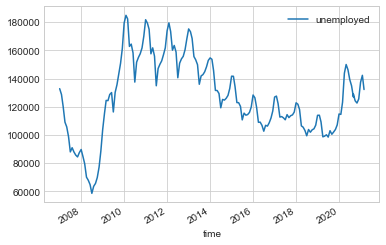

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

unempl_AD.loc[unempl_AD['gender'] == 'Total'].plot(ax=ax, x="time", y = "unemployed",legend=True);
plt.show()
fig.tight_layout()

From what we can see, we note the sharp rise in unemployment after the 2008 financial crisis. We also note a very apparent pattern in seasonal unemployment that rises at the start of each year, falls towards the summer and then begins to rise again come new years. For our analysis, we see that beginning in 2020, uemployment rises by roughly 50.000 people, which must be directly caused by the corona crisis. We do also note, however, that the seasonal unemployment is still in effect and that unemployment numbers are falling

If we now want to take a closer look at each municipality, we create a widget to better encompass all this information. We split out widget into each municipality and also split it up with regards to gender, which consists of Men, Women and Total.

In [12]:
def plot_interact(df, municipality, gender):
    I = df['municipality'] == municipality
    I &= df['gender'] == gender
    df.loc[I,:].plot(x='time', y = 'unemployed', style='-', legend=False)
widgets.interact(plot_interact, 
    df = widgets.fixed(unempl_M),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl_M.municipality.unique(), 
    value='Roskilde'),
    gender = widgets.Dropdown(description='Gender',
    options=unempl_M.gender.unique(),
    value='Men')
);

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

Using the widget, we come to a few conclusions regarding unemployment in danish municipalities:

When we look across genders, it appears that women and men were affected largely the same by the pandemic. However, if we look across the last decade, there does seem to be a pattern that womens unemployment rates are not as volatily (see Brøndby as an example). This discrepancy could be explained by the gender ratios in volatile areas of work like construction, which are more heavily affected by seasons and business cycles. A interesting contrast to this result is "Abroad", where men were largely unaffected compared to women. 

If we instead look across municipalities, a couple of pattern arise when regarding the pandemic. Larger municipalities, like Copenhagen and Aarhus, were hit remarkably harder (relatively to their size) than small municipalities like Aabenraa and Kerteminde. However, there does also appear to be a difference between municipalities on Sealand and Fyn/Jutland. If we compare Fredensborg and Ballerup to Holstebro and Randers, we see larger changes in the municipalities located in Sealand compared to Jutland, even if the municipalities in Jutland are larger. This is of course not completely consistent as for example Køge not having a very large reaction even if it is a larger city with close proximity to Copenhagen.

If we want to a bit closer on comparing each region, we create a graph that combines the total unemployed in each region.

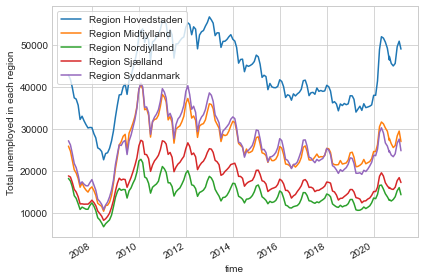

In [15]:
unempl_region = unempl_R[unempl_R['gender'] == 'Total']
unique_region = unempl_R['municipality'].unique()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)


for region in unique_region:
    unempl_region.loc[unempl_region['municipality'] == region].plot(x='time',y='unemployed',ax=ax, label=region)

ax.legend(frameon=True, loc='upper left')
ax.set_ylabel('Total unemployed in each region')
fig.tight_layout()

If we look at the above graph, we can clearly see how each region was affected by the pandemic. Region Hovedstaden were clearly hit relatively hardest with region Midtjylland and Nordjylland coming in 2nd and 3rd. Interestingly enough, Region Sjælland, which is the western and southern part of Sealand were mostly unaffected same as Region Syddanmark. An overarching reason for this could be the different work composition that exists within each region. Region Syddanmark and Region Sjælland are known for their large agriculture, which wasn't hit as much as for example restaurants and small shops, which are more common within the other regions, especially regions with larger cities like Copenhagen (Region Hovedstaden), Aarhus and Esbjerg (Region Midtjylland). 

Lastly, we can again look at the municipalities, but this time, we choose to look at the relative changes to unemployment rather than the levels. We choose again to create a widget for ease of visualization.

In [14]:
unempl_pct = unempl_M[unempl_M['gender'] == 'Total'] #create a variable only consisting of gender = total
unempl_pct['date'] = unempl_pct['time'].dt.date #Create a new time variable to avoid unnecessary clutter on x-axis

def plot_interact_pct(df, municipality):
    I = df['municipality'] == municipality
    df.loc[I,:].plot(x='date', y = 'pct change', kind='bar', style='-.', legend=False)
    plt.locator_params(axis='x', nbins=15) #Changes how many ticks are on the graph
widgets.interact(plot_interact_pct, 
    df = widgets.fixed(unempl_pct),
    municipality = widgets.Dropdown(description='Municipality', 
    options=unempl_M.municipality.unique(), 
    value='Roskilde')
);

interactive(children=(Dropdown(description='Municipality', index=73, options=('Aabenraa', 'Aalborg', 'Aarhus',…

From the above widget, we find similar results as we've discussed previously. There is an overall decreasing trend in unemployment over time. Most municipalities have oscillating relative changes between -10% and +10% over time. We note that the largest municipalities have a tendency to oscillate quicker from positive to negative than smaller municipalities (Example compare Billund to Aarhus), but this tendency isn't very strong when looking across the data.

# Conclusion

From our assignment, we conclude that the pandemic has had an effect on unemployment across danish municipalities with larger municipalities around Region Hovedstaden, Region Nordjylland and Region Midtjylland having felt the largest impacts. We also conclude that the pandemic has not limited the seasonal changes within the unemployment cycle, which is a positive for long term stability. We find that across genders, unemployment from the pandemic has not affected one gender more than the other in comparison to historically, where Men have a tendency to be more affected by the seasonal changes.